## Experiments

In [176]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

%matplotlib inline

In [204]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE

In [9]:
df = pd.read_csv("dataset/dataset.csv")

In [10]:
print ("No of rows & columns", df.shape)

No of rows & columns (965, 7)


In [11]:
## Columns
df.columns

Index(['Aggregation Type', 'Description', 'Dimensions', 'Metric',
       'Metric Display Name', 'Unit', 'resource'],
      dtype='object')

### Resources

In [15]:
print ("No of unique resources: %d" % (df.resource.value_counts().shape[0]))

No of unique resources: 59


In [19]:
def getResourceNamespace(resource):
    return resource.split('/')[0]

def getResourceName(resource):
    return "/".join(resource.split('/')[1:])

In [20]:
df['ResourceNamespace'] = df['resource'].apply(lambda x: getResourceNamespace(x))
df['ResourceName'] = df['resource'].apply(lambda x: getResourceName(x))

In [30]:
print ("No of resource namespaces: %d" % (df['ResourceNamespace'].value_counts().shape[0]))
print ("No of resource name: %d" % (df['ResourceName'].value_counts().shape[0]))

No of resource namespaces: 34
No of resource name: 50


### Aggreagation Type

col_0             count
Aggregation Type       
Average             309
Count                 5
Last                  6
Maximum             123
Total               522


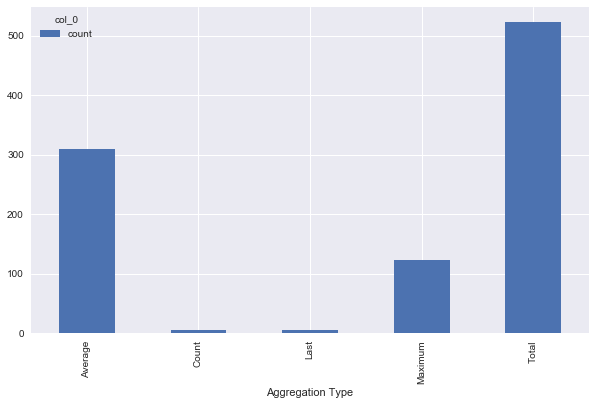

In [59]:
ct = pd.crosstab(df['Aggregation Type'], 'count')
print (ct)

ct.plot(kind='bar', figsize=(10, 6))

### Unit

col_0           count
Unit                 
Bytes             125
BytesPerSecond     37
Count             637
CountPerSecond     29
MilliSeconds        2
Milliseconds       24
Percent            80
Seconds            31


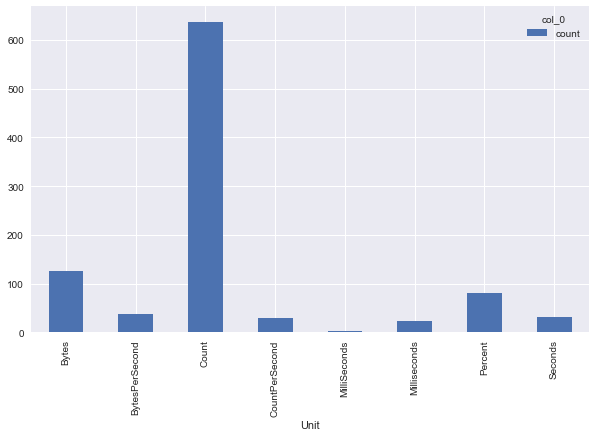

In [58]:
ct = pd.crosstab(df['Unit'], 'count')
print (ct)

ct.plot(kind='bar', figsize=(10, 6))

### Metric & Metric Display Name

It seems more everyone has configured the metric name differently - let's see if we can use charecter level (n-gram) vectorization to cluster similar ones;

In [251]:
import re
metric = df['Metric'].values
metric = np.unique(np.array(metric))

print ("No of metrics before pre-processing: %d" % metric.shape[0])
# for i, m in enumerate(metric):
#     metric[i] = ''.join(ch for ch in m.lower() if ch.isalpha())
    
# print ("No of metrics after pre-processing: %d" % metric.shape[0])

No of metrics before pre-processing: 583


In [252]:
cv = CountVectorizer(analyzer='char', ngram_range=(1,4))
vectors = cv.fit_transform(metric)
vectors = vectors.toarray()
vectors.shape

(583, 4473)

In [253]:
cluster = DBSCAN(eps=8, min_samples=2)
cluster.fit(vectors)

mdf = pd.DataFrame(metric, columns=['metric'])
mdf['label'] = cluster.labels_
# mdf['label'].value_counts()

In [254]:
print ("No of clusters: %d" % (mdf['label'].max() + 1))
for i in range(mdf['label'].max()):
    print ("label %d" % i)
    print (mdf[mdf['label'] == i])
    print ()

No of clusters: 29
label 0
                                metric  label
0                        actionlatency      0
1                     actionscompleted      0
2                        actionsfailed      0
3                       actionsskipped      0
4                       actionsstarted      0
5                     actionssucceeded      0
6                 actionsuccesslatency      0
7                actionthrottledevents      0
8                    activeconnections      0
9                      activelisteners      0
10                      activemessages      0
11                      activerequests      0
12                  activityfailedruns      0
13               activitysucceededruns      0
17            amlcalloutfailedrequests      0
18               amlcalloutinputevents      0
19                  amlcalloutrequests      0
20                      appconnections      0
21                 attestationattempts      0
22                        availability      0
28     

In [255]:
vectors_reduced = TSNE(n_components=2).fit_transform(vectors)

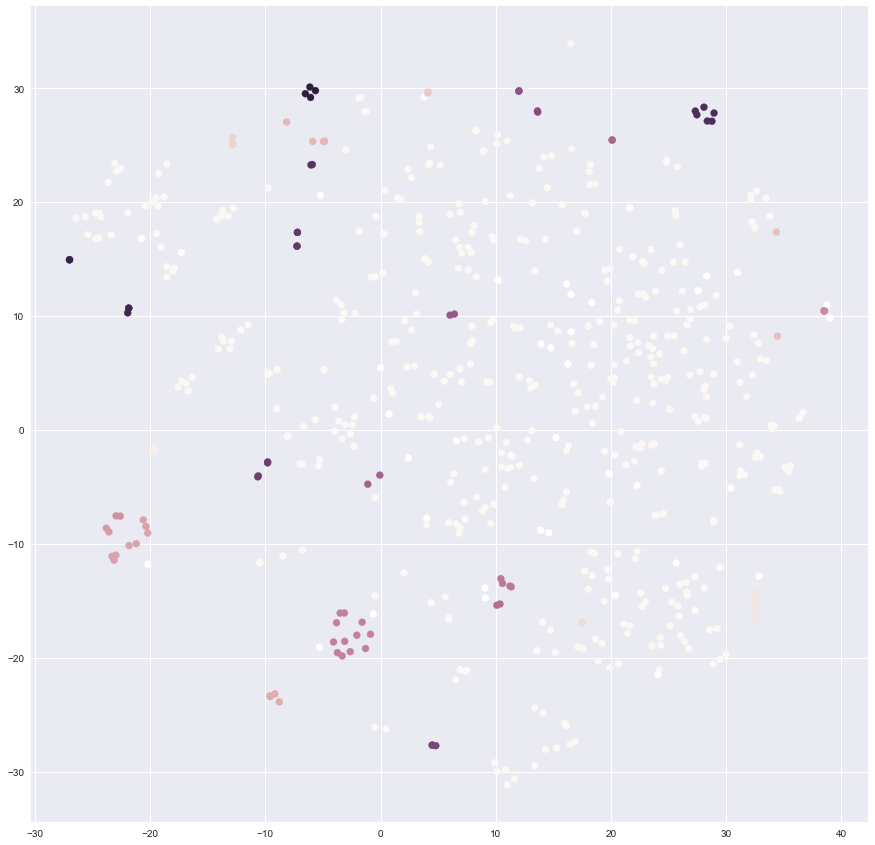

In [256]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
plt.figure(figsize=(15, 15))
cluster.labels_ + 100

scatter = plt.scatter(vectors_reduced[:, 0], vectors_reduced[:, 1], label=cluster.labels_, c=cluster.labels_, cmap=cmap)